In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
import tensorflow as tf
import gym
import os
import matplotlib.pyplot as plt


In [4]:
# Configuración enviroment
env_name = 'Acrobot-v1'
env = gym.make(env_name)

# Semillas de reproducibilidad
np.random.seed(123)
env.seed(123)

# Set observations and actions spaces
n_obs = env.observation_space
nb_actions = env.action_space.n

In [ ]:
# Implementación de la red mejorada con arquitectura Dueling DQN
def build_dueling_model_improved(window_length, input_shape, nb_actions):
    input_layer = tf.keras.layers.Input(shape=(window_length,) + input_shape)
    flatten = tf.keras.layers.Flatten()(input_layer)

    # Red compartida
    shared_dense = tf.keras.layers.Dense(256, activation='relu')(flatten)
    shared_dense = tf.keras.layers.Dense(256, activation='relu')(shared_dense)

    # Stream de ventaja
    advantage_fc = tf.keras.layers.Dense(128, activation='relu')(shared_dense)
    advantage_fc = tf.keras.layers.Dense(64, activation='relu')(advantage_fc)
    advantage = tf.keras.layers.Dense(nb_actions, activation='linear')(advantage_fc)

    # Stream de valor
    value_fc = tf.keras.layers.Dense(128, activation='relu')(shared_dense)
    value_fc = tf.keras.layers.Dense(64, activation='relu')(value_fc)
    value = tf.keras.layers.Dense(1, activation='linear')(value_fc)

    # Cálculo Q(s, a) = V(s) + A(s, a) - promedio(A(s, a))
    output = tf.keras.layers.Add()([
        value,
        tf.keras.layers.Subtract()([
            advantage,
            tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(advantage)
        ])
    ])

    return tf.keras.models.Model(inputs=input_layer, outputs=output)


# Crear modelo mejorado
window_length = 4
input_shape = env.observation_space.shape
improved_dueling_model = build_dueling_model_improved(window_length, input_shape, nb_actions)
improved_dueling_model.summary()

# Configurar optimización de precisión mixta
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Crear agente mejorado
dueling_dqn_improved = DQNAgent(
    model=improved_dueling_model,
    nb_actions=nb_actions,
    memory=SequentialMemory(limit=200000, window_length=window_length),
    policy=LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps',
        value_max=1.0,
        value_min=0.05,
        value_test=0.01,
        nb_steps=100000
    ),
    nb_steps_warmup=1000,
    gamma=0.99,
    target_model_update=500,
    train_interval=8,
    batch_size=64
)
dueling_dqn_improved.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])

# Entrenar el modelo mejorado
nb_steps = 200000
dueling_history_improved = dueling_dqn_improved.fit(env, nb_steps=nb_steps, visualize=False, verbose=2)





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 6)]       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6400        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
______________________________________________________________________________________________

2024-12-14 22:20:01.675375: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-14 22:20:01.704074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-14 22:20:01.710936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.807GHz coreCount: 28 deviceMemorySize: 11.66GiB deviceMemoryBandwidth: 335.32GiB/s
2024-12-14 22:20:01.710980: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-14 22:20:01.734923: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-12-14 22:20:01.734977: I tensorflow/stream_executor/pl

Training for 200000 steps ...


/home/juan/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    500/200000: episode: 1, duration: 0.377s, episode steps: 500, steps per second: 1326, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1000/200000: episode: 2, duration: 0.338s, episode steps: 500, steps per second: 1477, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.040 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/home/juan/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1500/200000: episode: 3, duration: 1.337s, episode steps: 500, steps per second: 374, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.054 [0.000, 2.000],  loss: 0.070980, mae: 0.446107, mean_q: -0.445872, mean_eps: 0.988106
   2000/200000: episode: 4, duration: 0.775s, episode steps: 500, steps per second: 645, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.044 [0.000, 2.000],  loss: 0.075153, mae: 1.043140, mean_q: -1.389772, mean_eps: 0.983394
   2500/200000: episode: 5, duration: 0.790s, episode steps: 500, steps per second: 633, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.082 [0.000, 2.000],  loss: 0.062427, mae: 1.737605, mean_q: -2.437035, mean_eps: 0.978644
   3000/200000: episode: 6, duration: 0.758s, episode steps: 500, steps per second: 660, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.968 [0.000, 2.000],  loss: 0.062926, mae: 2.367524, mean_q

NameError: name 'os' is not defined

/home/juan/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Testing for 10 episodes ...
Episode 1: reward: -172.000, steps: 173
Episode 2: reward: -79.000, steps: 80
Episode 3: reward: -79.000, steps: 80
Episode 4: reward: -75.000, steps: 76
Episode 5: reward: -99.000, steps: 100
Episode 6: reward: -86.000, steps: 87
Episode 7: reward: -82.000, steps: 83
Episode 8: reward: -77.000, steps: 78
Episode 9: reward: -70.000, steps: 71
Episode 10: reward: -79.000, steps: 80


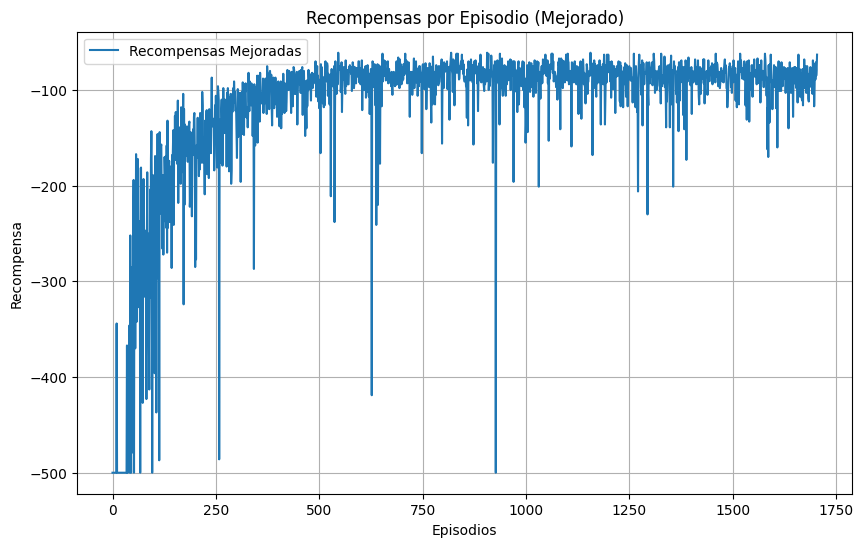

In [ ]:
# Crear directorio para guardar resultados
output_dir = f"results_{env_name}_juan"
os.makedirs(output_dir, exist_ok=True)

# Guardar modelo completo y pesos
dueling_dqn_improved.model.save(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_model.h5'))
dueling_dqn_improved.save_weights(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_weights.h5f'), overwrite=True)

# Exportar logs de entrenamiento a CSV
train_history_df = pd.DataFrame(dueling_history_improved.history)
train_history_df.to_csv(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_train_log.csv'), index=False)

# Evaluar el modelo mejorado
dueling_test_improved = dueling_dqn_improved.test(env, nb_episodes=10, visualize=False)
test_rewards = dueling_test_improved.history['episode_reward']

# Guardar recompensas de prueba

np.savetxt(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_test_rewards.csv'), test_rewards, delimiter=',')

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(range(len(dueling_history_improved.history['episode_reward'])), dueling_history_improved.history['episode_reward'], label='Recompensas Mejoradas')
plt.xlabel('Episodios')
plt.ylabel('Recompensa')
plt.title('Recompensas por Episodio (Mejorado)')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'reward_per_episode_improved.png'))
plt.show()